In [ ]:
!unzip data.zip

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split
import glob

print("데이터 분할 스크립트를 시작합니다.")

# --- 설정 변수 (필요시 수정) ---

# 1. 원본 이미지 데이터가 있는 최상위 폴더
SOURCE_DIR = './data'

# 2. 새로 생성할 train/test 폴더가 위치할 최상위 폴더
DEST_DIR = './data_split'

# 3. 테스트 데이터셋의 비율 (예: 0.2는 20%)
TEST_SPLIT_RATIO = 0.2

# 4. 처리할 이미지 확장자
IMAGE_EXTENSIONS = ['*.jpg', '*.jpeg', '*.png', '*.bmp']

# ------------------------------------

# 목적지 폴더 생성
train_full_path = os.path.join(DEST_DIR, 'train')
test_full_path = os.path.join(DEST_DIR, 'test')

if os.path.exists(DEST_DIR):
    print(f"'{DEST_DIR}' 폴더가 이미 존재합니다. 기존 폴더를 삭제하고 다시 생성합니다.")
    shutil.rmtree(DEST_DIR)

os.makedirs(train_full_path, exist_ok=True)
os.makedirs(test_full_path, exist_ok=True)
print(f"'{train_full_path}' 와 '{test_full_path}' 폴더를 생성했습니다.")

# 원본 디렉토리에서 클래스(하위 폴더) 목록 가져오기
try:
    class_names = [d for d in os.listdir(SOURCE_DIR) if os.path.isdir(os.path.join(SOURCE_DIR, d))]
    if not class_names:
        print(f"오류: '{SOURCE_DIR}' 폴더에 하위 폴더(클래스)가 없습니다.")
        exit()
    print(f"발견된 클래스: {class_names}")

except FileNotFoundError:
    print(f"오류: 원본 폴더 '{SOURCE_DIR}'를 찾을 수 없습니다. 경로를 확인해주세요.")
    exit()


# 각 클래스별로 파일 분할 및 복사
for class_name in class_names:
    print(f"\n'{class_name}' 클래스 처리 중...")

    # 목적지 하위 폴더 생성
    os.makedirs(os.path.join(train_full_path, class_name), exist_ok=True)
    os.makedirs(os.path.join(test_full_path, class_name), exist_ok=True)

    # 현재 클래스의 모든 이미지 파일 경로 가져오기
    source_class_path = os.path.join(SOURCE_DIR, class_name)
    all_files = []
    for ext in IMAGE_EXTENSIONS:
        all_files.extend(glob.glob(os.path.join(source_class_path, ext)))

    if not all_files:
        print(f"'{class_name}' 폴더에 이미지가 없습니다. 다음 클래스로 넘어갑니다.")
        continue

    # 훈련용과 테스트용 파일로 분할
    train_files, test_files = train_test_split(
        all_files,
        test_size=TEST_SPLIT_RATIO,
        random_state=42 # 재현성을 위해 random_state 설정
    )

    # 훈련 파일 복사
    for f in train_files:
        shutil.copy(f, os.path.join(train_full_path, class_name))

    # 테스트 파일 복사
    for f in test_files:
        shutil.copy(f, os.path.join(test_full_path, class_name))

    print(f"'{class_name}' 클래스 처리 완료: 훈련 {len(train_files)}개, 테스트 {len(test_files)}개")

print("\n모든 데이터 분할 및 복사가 완료되었습니다!")

데이터 분할 스크립트를 시작합니다.
'./data_split/train' 와 './data_split/test' 폴더를 생성했습니다.
발견된 클래스: ['green_area', 'desert', 'cloudy', 'water']

'green_area' 클래스 처리 중...
'green_area' 클래스 처리 완료: 훈련 1200개, 테스트 300개

'desert' 클래스 처리 중...
'desert' 클래스 처리 완료: 훈련 904개, 테스트 227개

'cloudy' 클래스 처리 중...
'cloudy' 클래스 처리 완료: 훈련 1200개, 테스트 300개

'water' 클래스 처리 중...
'water' 클래스 처리 완료: 훈련 1200개, 테스트 300개

모든 데이터 분할 및 복사가 완료되었습니다!


In [11]:
# ## 1. Setup and Imports
# 필요한 라이브러리를 모두 불러옵니다.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

# ---

# ## 2. Hyperparameters and Configuration
# 모델과 데이터 로딩에 필요한 주요 파라미터를 설정합니다.
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 100
EPOCHS = 30

# 데이터 경로 설정
# Colab 또는 다른 환경에서 실행하는 경우, 데이터셋 경로를 올바르게 수정해주세요.
train_path = '/content/data_split/train'
test_path = '/content/data_split/test'

if not os.path.exists(train_path) or not os.path.exists(test_path):
    raise FileNotFoundError


Class names found: ['cloudy', 'desert', 'green_area', 'water']


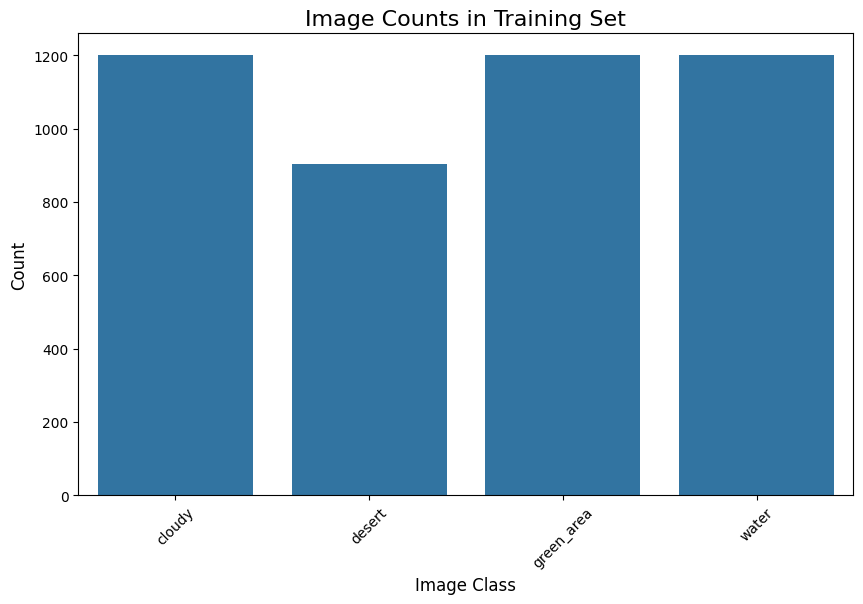

In [12]:
# ## 3. Exploratory Data Analysis (EDA)
if os.path.exists(train_path) and os.path.exists(test_path):
    class_names = sorted(os.listdir(train_path))
    print(f"Class names found: {class_names}")

    # 클래스별 데이터 수량 확인 및 시각화
    train_counts = {cls: len(os.listdir(os.path.join(train_path, cls))) for cls in class_names}

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
    plt.title('Image Counts in Training Set', fontsize=16)
    plt.xlabel('Image Class', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

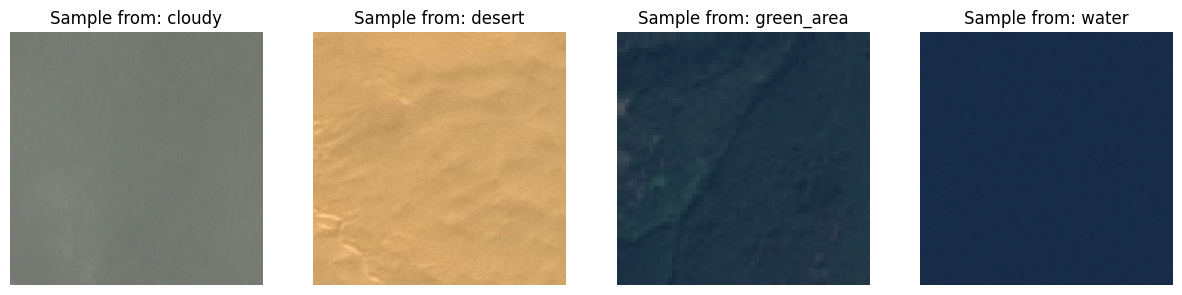

In [13]:
# 각 클래스별 샘플 이미지 확인
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(train_path, class_name)
    random_image = random.choice(os.listdir(class_dir))
    img = plt.imread(os.path.join(class_dir, random_image))

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.title(f'Sample from: {class_name}')
    plt.axis('off')
plt.show()

In [14]:
# ## 4. Data Augmentation & Loading
# ImageDataGenerator를 사용하여 데이터 증강 및 배치를 생성합니다.
if os.path.exists(train_path) and os.path.exists(test_path):
    # 훈련 데이터용 ImageDataGenerator (증강 적용)
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2 # 훈련 데이터의 20%를 검증용으로 사용
    )

    # 테스트/검증 데이터용 ImageDataGenerator (증강 미적용)
    test_datagen = ImageDataGenerator(rescale=1./255)

    # 제너레이터 생성
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training' # 훈련용 데이터
    )

    validation_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation' # 검증용 데이터
    )

    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    # 클래스 인덱스 확인
    print("\nClass Indices:", train_generator.class_indices)

Found 3604 images belonging to 4 classes.
Found 900 images belonging to 4 classes.
Found 1127 images belonging to 4 classes.

Class Indices: {'cloudy': 0, 'desert': 1, 'green_area': 2, 'water': 3}


In [15]:
# ## 5. Model Building (Transfer Learning with InceptionV3)
if os.path.exists(train_path) and os.path.exists(test_path):
    # InceptionV3 베이스 모델 로드 (ImageNet 가중치 사용)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # 베이스 모델의 가중치 동결
    for layer in base_model.layers:
        layer.trainable = False

    # 커스텀 분류기(head) 추가
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 모델 컴파일
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │         96 │ conv2d_94[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_94       │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 109, 109,  │      9,216 │ activation_94[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_95[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_95       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 109, 109,  │     18,432 │ activation_95[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_96[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_96       │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 54, 54,    │          0 │ activation_96[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 54, 54,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_97[0][0]   │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_97       │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 52, 52,    │    138,240 │ activation_97[0]… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_98[0][0]   │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_98       │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 23,905,060 (91.19 MB)

 Trainable params: 2,102,276 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [16]:
# ## 6. Model Training
if os.path.exists(train_path) and os.path.exists(test_path):
    # 콜백 설정
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

    # 모델 학습
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[reduce_lr, early_stopping]
    )

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7015 - loss: 0.7919 - val_accuracy: 0.9189 - val_loss: 0.2146 - learning_rate: 0.0010
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9427 - loss: 0.1840 - val_accuracy: 0.9589 - val_loss: 0.1303 - learning_rate: 0.0010
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9457 - loss: 0.1750 - val_accuracy: 0.9344 - val_loss: 0.1920 - learning_rate: 0.0010
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9310 - loss: 0.1807 - val_accuracy: 0.9433 - val_loss: 0.1682 - learning_rate: 0.0010
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.9553 - loss: 0.1143 - val_accuracy: 0.9633 - val_loss: 0.0846 - learning_rate: 0.0010
Epoch 6/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.9730 - loss: 0.0772 - val_accuracy: 0.9711 - val_loss: 0.0860 - learning_rate: 0.0010
Epoch 7/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9638 - loss: 0.1041 - val_accuracy: 

12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 800ms/step - accuracy: 0.9806 - loss: 0.0612

Test Accuracy: 98.05%


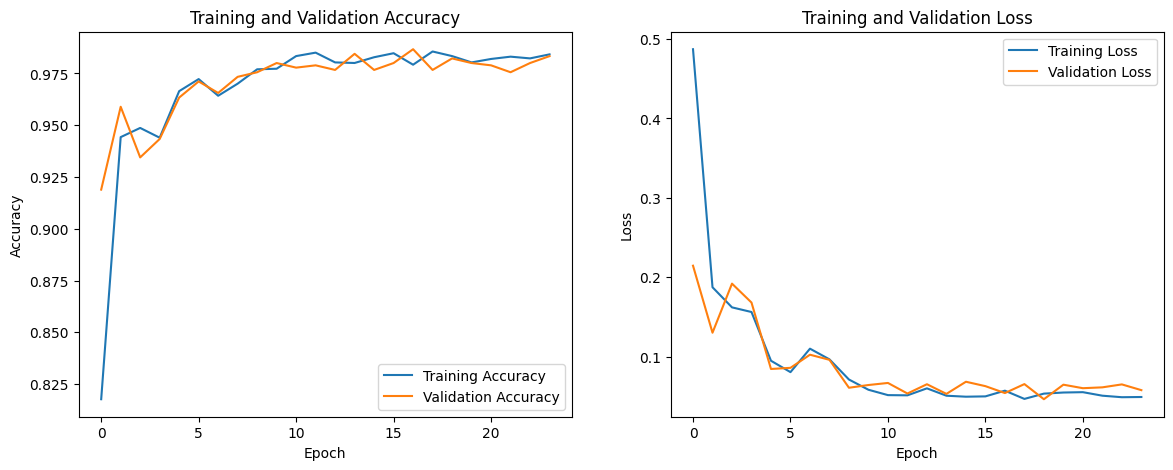

In [17]:
# ## 7. Performance Evaluation
# 최종 테스트 데이터셋 성능 평가
loss, accuracy = model.evaluate(test_generator)
print(f'\nTest Accuracy: {accuracy*100:.2f}%')

# ### 7.1. Accuracy and Loss Curves
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 719ms/step


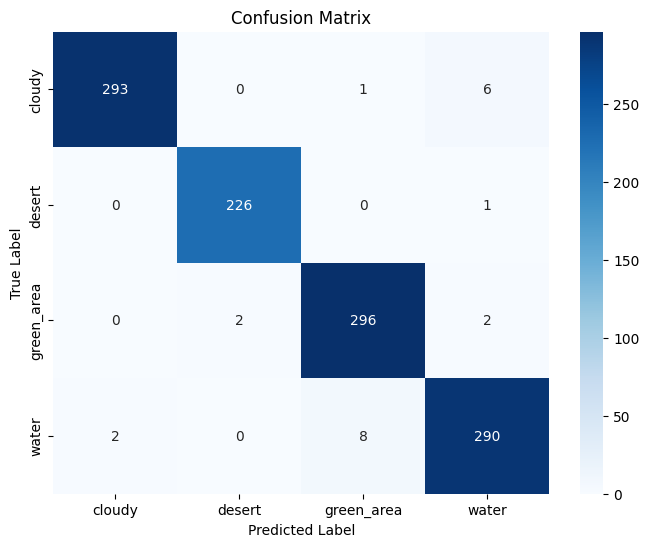

In [18]:
# ### 7.2. Confusion Matrix & Classification Report
# 테스트 데이터셋에 대한 예측
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [19]:
# Classification Report
print('\nClassification Report')
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report
              precision    recall  f1-score   support

      cloudy       0.99      0.98      0.98       300
      desert       0.99      1.00      0.99       227
  green_area       0.97      0.99      0.98       300
       water       0.97      0.97      0.97       300

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127




Total misclassified images: 22



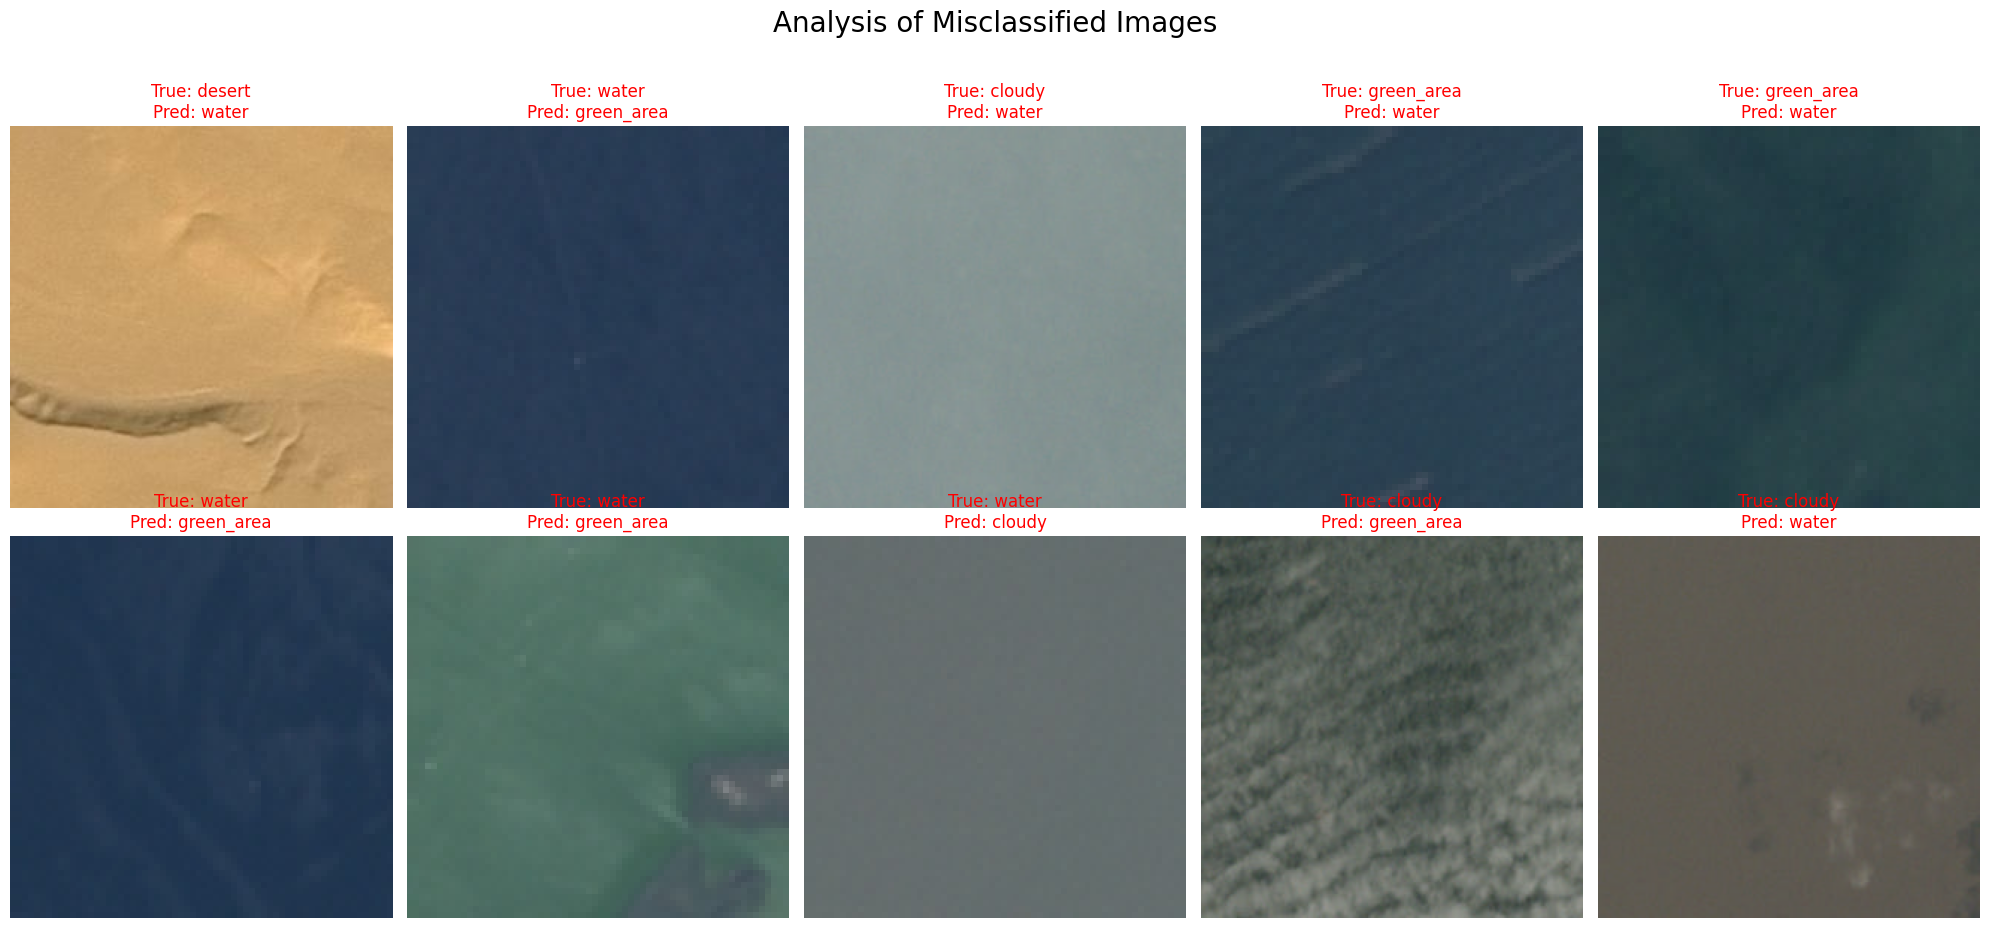

In [20]:
# ### 7.3. Analysis of Misclassified Images
# 오분류된 이미지 인덱스 찾기
misclassified_indices = np.where(y_pred != y_true)[0]

if len(misclassified_indices) > 0:
    print(f"\nTotal misclassified images: {len(misclassified_indices)}\n")

    # 일부 오분류 이미지 시각화 (최대 10개)
    plt.figure(figsize=(20, 10))
    random_indices = np.random.choice(misclassified_indices, size=min(10, len(misclassified_indices)), replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(2, 5, i + 1)
        img_path = test_generator.filepaths[idx]
        img = plt.imread(img_path)
        plt.imshow(img)

        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]

        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=12, color='red')
        plt.axis('off')

    plt.suptitle('Analysis of Misclassified Images', fontsize=20)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("Congratulations! No images were misclassified in the test set.")